<a href="https://colab.research.google.com/github/itzyishu/lip-reading-/blob/main/AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Install and Import Dependencies**

In [61]:
!pip list

Package                                  Version
---------------------------------------- --------------------
absl-py                                  1.4.0
absolufy-imports                         0.3.1
accelerate                               1.11.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.1
aiosignal                                1.4.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.0
altair                                   5.5.0
annotated-doc                            0.0.3
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.11.0
anywidget                                0.9.18
argon2-cffi                        

In [62]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [63]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [64]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [65]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    #print ("hi")
except:
   # print("no")
    pass

# **1. Build Data Loading Functions**

In [66]:
import gdown

In [67]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

#to stop download

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=2904bdb7-5777-4d85-85e5-7551119cb4c2
To: /content/data.zip
100%|██████████| 423M/423M [00:03<00:00, 111MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [68]:
# def load_video(path:str) -> List[float]:

#     cap = cv2.VideoCapture(path)
#     frames = []
#     for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
#         ret, frame = cap.read()
#         frame = tf.image.rgb_to_grayscale(frame)
#         frames.append(frame[190:236,80:220,:])
#     cap.release()

#     mean = tf.math.reduce_mean(frames)
#     std = tf.math.reduce_std(tf.cast(frames, tf.float32))
#     return tf.cast((frames - mean), tf.float32) / std


def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if ret:  # ← ADD THIS CHECK
            frame = tf.image.rgb_to_grayscale(frame)
            frames.append(frame[190:236, 80:220, :])
    cap.release()

    # Ensure frames is not empty
    if len(frames) == 0:
        raise ValueError(f"No frames loaded from {path}")

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    # Avoid division by zero
    std = tf.maximum(std, 1e-8)

    return tf.cast((frames - mean), tf.float32) / std

In [69]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [70]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [71]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [72]:
num_to_char([9,  19,  9, 21])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'i', b's', b'i', b'u'], dtype=object)>

In [73]:
char_to_num.get_vocabulary()

['',
 np.str_('a'),
 np.str_('b'),
 np.str_('c'),
 np.str_('d'),
 np.str_('e'),
 np.str_('f'),
 np.str_('g'),
 np.str_('h'),
 np.str_('i'),
 np.str_('j'),
 np.str_('k'),
 np.str_('l'),
 np.str_('m'),
 np.str_('n'),
 np.str_('o'),
 np.str_('p'),
 np.str_('q'),
 np.str_('r'),
 np.str_('s'),
 np.str_('t'),
 np.str_('u'),
 np.str_('v'),
 np.str_('w'),
 np.str_('x'),
 np.str_('y'),
 np.str_('z'),
 np.str_("'"),
 np.str_('?'),
 np.str_('!'),
 np.str_('1'),
 np.str_('2'),
 np.str_('3'),
 np.str_('4'),
 np.str_('5'),
 np.str_('6'),
 np.str_('7'),
 np.str_('8'),
 np.str_('9'),
 np.str_(' ')]

In [74]:
char_to_num(['i','s','h','u'])


<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 9, 19,  8, 21])>

In [75]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [76]:
# def load_data(path: str):
#     path = bytes.decode(path.numpy())
#     #file_name = path.split('/')[-1].split('.')[0]
#     # File name splitting for windows
#     file_name = path.split('\\')[-1].split('.')[0]
#     video_path = os.path.join('data','s1',f'{file_name}.mpg')
#     alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
#     frames = load_video(video_path)
#     alignments = load_alignments(alignment_path)

#     return frames,

def load_data(path: str):
    path = bytes.decode(path.numpy())

    # Use os.path.basename for cross-platform compatibility
    file_name = path.split('\\')[-1].split('.')[0]

    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [77]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [78]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [79]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

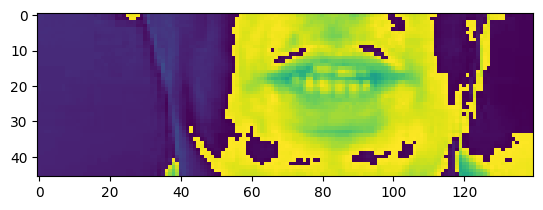

In [80]:
plt.imshow(frames[40])

In [81]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [82]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [83]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# **2. Create Data Pipelines**

In [84]:
from matplotlib import pyplot as plt

In [85]:
def load_data(path: str):
    path = bytes.decode(path.numpy())

    # Handle both forward and backward slashes
    file_name = path.replace('\\', '/').split('/')[-1].split('.')[0]

    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

# def load_video(path: str) -> List[float]:
#     cap = cv2.VideoCapture(path)
#     frames = []

#     for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
#         ret, frame = cap.read()
#         if ret and frame is not None:  # ← ADD THIS CHECK
#             # Verify frame has valid dimensions
#             if frame.shape[0] > 236 and frame.shape[1] > 220:
#                 frame = tf.image.rgb_to_grayscale(frame)
#                 frames.append(frame[190:236, 80:220, :])

#     cap.release()

#     # CRITICAL: Handle cases where frames list is empty or too short
#     if len(frames) == 0:
#         # Create a dummy black frame if no frames loaded
#         dummy_frame = tf.zeros((46, 140, 1), dtype=tf.uint8)
#         frames = [dummy_frame] * 75
#     elif len(frames) < 75:
#         # Pad with the last frame if too few
#         while len(frames) < 75:
#             frames.append(frames[-1])
#     else:
#         # Take only first 75 frames
#         frames = frames[:75]

#     # Convert to tensor
#     frames = tf.stack(frames)

#     # Normalize
#     mean = tf.math.reduce_mean(frames)
#     std = tf.math.reduce_std(tf.cast(frames, tf.float32))
#     std = tf.maximum(std, 1e-8)  # Avoid division by zero

#     return tf.cast((frames - mean), tf.float32) / std

In [86]:
# data = tf.data.Dataset.list_files('./data/s1/*.mpg')
# data = data.shuffle(500, reshuffle_each_iteration=False)
# data = data.map(mappable_function)
# data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
# data = data.prefetch(tf.data.AUTOTUNE)
# # Added for split
# train = data.take(450)
# test = data.skip(450)

# Recreate the dataset with the fixed functions
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

# Test before training
sample = train.as_numpy_iterator().next()
print("Train sample shapes:", sample[0].shape, sample[1].shape)
print("Values range:", sample[0].min(), sample[0].max())

Train sample shapes: (2, 75, 46, 140, 1) (2, 40)
Values range: 0.0 10.11826


In [87]:
len(test)

50

In [88]:
frames, alignments = data.as_numpy_iterator().next()

In [89]:
len(frames)

2

In [90]:
#
alignments

array([[19,  5, 20, 39, 18,  5,  4, 39,  2, 25, 39, 21, 39, 19,  9, 24,
        39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39, 23,  8,  9, 20,  5, 39,  9, 14, 39, 15, 39, 20,
        23, 15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [91]:
sample = data.as_numpy_iterator()

In [92]:
val = sample.next(); val[0]

array([[[[[1.2281978 ],
          [1.2281978 ],
          [1.2281978 ],
          ...,
          [0.5373365 ],
          [0.49895534],
          [0.422193  ]],

         [[1.2281978 ],
          [1.2281978 ],
          [1.2281978 ],
          ...,
          [0.5373365 ],
          [0.49895534],
          [0.49895534]],

         [[1.1898166 ],
          [1.1898166 ],
          [1.1898166 ],
          ...,
          [0.3838118 ],
          [0.30704945],
          [0.65248007]],

         ...,

         [[0.80600476],
          [0.80600476],
          [0.80600476],
          ...,
          [0.6908612 ],
          [8.904434  ],
          [7.48433   ]],

         [[0.7676236 ],
          [0.7676236 ],
          [0.7676236 ],
          ...,
          [0.88276714],
          [9.441771  ],
          [7.369187  ]],

         [[0.7676236 ],
          [0.7676236 ],
          [0.7676236 ],
          ...,
          [0.9979107 ],
          [0.26866826],
          [7.7146173 ]]],


        [[[1.1898

In [93]:
#imageio.mimsave('./animation.gif', val[0][0], fps=10)

video = val[0][0]  # [num_frames, height, width, channels]

# Convert to uint8 if needed
if video.dtype in [np.float32, np.float64]:
    video = (video * 255).astype(np.uint8)

# Remove channel dimension if grayscale
if video.shape[-1] == 1:
    video = video.squeeze(-1)

imageio.mimsave('./animation.gif', video, fps=10)

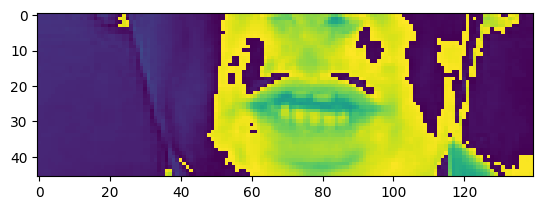

In [94]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][1][35])

In [95]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay red by e eight please'>

# **3. Design the Deep Neural Network**

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler



In [98]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [99]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [100]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
5*17*75#above cell output maxpooling 3d

6375

In [102]:
yhat = model.predict(val[0])
#Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [103]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'rrrrr333gggggggg333gggggggggggggggggggggggggggggggggggggggggggggggggg!!!!!!'>

In [104]:

tf.argmax(yhat[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([18, 18, 18, 18, 18, 32, 32, 32,  7,  7,  7,  7,  7,  7,  7,  7, 32,
       32, 32,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7, 29, 29, 29, 29, 29, 29])>

In [105]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'rrrrr333gggggggg333gggggggggggggggggggggggggggggggggggggggggggggggggg!!!!!!'>

In [106]:
model.input_shape

(None, 75, 46, 140, 1)

In [107]:
model.output_shape

(None, 75, 41)

# **4. Setup Training Options and Train**

In [108]:
def load_video(path: str):
    cap = cv2.VideoCapture(path)
    frames = []

    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if ret and frame is not None:
            if frame.shape[0] > 236 and frame.shape[1] > 220:
                frame = tf.image.rgb_to_grayscale(frame)
                frames.append(frame[190:236, 80:220, :])

    cap.release()

    # Ensure exactly 75 frames
    if len(frames) == 0:
        frames = [tf.zeros((46, 140, 1), dtype=tf.uint8)] * 75
    elif len(frames) < 75:
        while len(frames) < 75:
            frames.append(frames[-1])
    else:
        frames = frames[:75]

    frames = tf.stack(frames)
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    std = tf.maximum(std, 1e-8)

    return tf.cast((frames - mean), tf.float32) / std


def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = os.path.basename(path).split('.')[0]

    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments


def mappable_function(path: str):
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))

    # CRITICAL: Set explicit shapes to avoid dynamic shape issues
    result[0].set_shape([75, 46, 140, 1])  # frames shape
    result[1].set_shape([None])  # alignments shape (variable length)

    return result

In [109]:
# Clear any cached data
import importlib
import sys

# Recreate dataset from scratch
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function, num_parallel_calls=1)  # Use 1 to avoid parallel issues
data = data.padded_batch(2, padded_shapes=([75, 46, 140, 1], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

# Test extensively
print("Testing multiple batches...")
for i, sample in enumerate(train.take(5)):
    print(f"Batch {i}: shapes = {sample[0].shape}, {sample[1].shape}")
    if tf.reduce_any(tf.math.is_nan(sample[0])):
        print(f"  ⚠️ Batch {i} contains NaN!")
    if sample[0].shape[2] == 0 or sample[0].shape[3] == 0:
        print(f"  ❌ Batch {i} has zero dimensions!")

Testing multiple batches...
Batch 0: shapes = (2, 75, 46, 140, 1), (2, 40)
Batch 1: shapes = (2, 75, 46, 140, 1), (2, 40)
Batch 2: shapes = (2, 75, 46, 140, 1), (2, 40)
Batch 3: shapes = (2, 75, 46, 140, 1), (2, 40)
Batch 4: shapes = (2, 75, 46, 140, 1), (2, 40)


In [110]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [114]:
#Automatic Speech Regocination model using CTC through video frames maybe(Credits)
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [111]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [115]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [116]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [117]:
schedule_callback = LearningRateScheduler(scheduler)

In [118]:
example_callback = ProduceExample(test)

In [ ]:

model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
277/450 ━━━━━━━━━━━━━━━━━━━━ 2:58 1s/step - loss: 77.5480

# **5. Make a Prediction**

In [ ]:

url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('/content/models/checkpoint.weights.h5')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:

sample = test_data.next()

In [ ]:

yhat = model.predict(sample[0])